# tf_flowers

[Data catalog](https://www.tensorflow.org/datasets/catalog/tf_flowers)

Most code follows the 
* [Load and preprocess images guide](https://www.tensorflow.org/tutorials/load_data/images)
* [Image classification guide](https://www.tensorflow.org/tutorials/images/classification)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

keras = tf.keras
tf.__version__

'2.5.0'

In [2]:
ds, info = tfds.load('tf_flowers', with_info = True)
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/Users/zhengjiaxun/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

# Read Data from Tensorflow Dataset

In [22]:
import numpy as np

tf.random.set_seed(1)
np.random.seed(1)

# https://www.tensorflow.org/datasets/api_docs/python/tfds/load
(train_ds, valid_ds, test_ds), info = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files = True,
    as_supervised = True,
    with_info = True,
)

In [4]:
print(info.features['label'].num_classes)

flower_names = info.features['label'].names
print(flower_names)

5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
print(info.features['image'].shape)
print(info.features['image'].dtype)

(None, None, 3)
<dtype: 'uint8'>


In [6]:
print(info.splits['train'].num_examples)

3670


## Visualization of Some Samples

,image,label
0,,3 (sunflowers)
1,,3 (sunflowers)
2,,0 (dandelion)
3,,0 (dandelion)
4,,0 (dandelion)

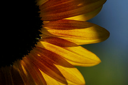
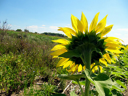
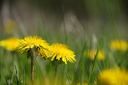
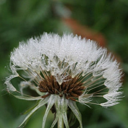
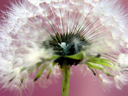

In [7]:
tfds.as_dataframe(train_ds.take(5), info)

In [8]:
import pandas as pd

shapes = []
for image, _ in train_ds.take(5):
    shapes.append([image.shape[0], image.shape[1], image.shape[2]])
    
df = pd.DataFrame(shapes)
df.columns = ['width', 'height', 'channel']
print(f'Width mean: {df.width.mean()} - height mean: {df.height.mean()}')

width = 200
height = 200
print(f'We use width: {width} - height: {height}')

Width mean: 228.8 - height mean: 304.0
We use width: 200 - height: 200


In [76]:
batch_size = 128

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/smart_resize
# https://www.tensorflow.org/api_docs/python/tf/image/resize
def resize_image(image, label):
    image = keras.preprocessing.image.smart_resize(image, (width, height))
    return image, label

def normalize_image(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Parameter augmentation will be used later in data augmentation
def create_train_batch_ds(ds, transformations, augmentation = None):
    for tr in transformations:
        ds = ds.map(tr, num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(1000, seed = 1, reshuffle_each_iteration = False)
    ds = ds.batch(batch_size)
    if augmentation is not None:
        ds = ds.map(augmentation, num_parallel_calls = tf.data.AUTOTUNE)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

first_transformations = [resize_image, normalize_image]
train_batch_ds = create_train_batch_ds(train_ds, first_transformations)

In [44]:
def create_test_batch_ds(ds, transformations):
    for tr in transformations:
        ds = ds.map(tr, num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

valid_batch_ds = create_test_batch_ds(valid_ds, first_transformations)
test_batch_ds = create_test_batch_ds(test_ds, first_transformations)

In [45]:
for (image_batch, label_batch) in train_batch_ds.take(1):
    print(image_batch.shape)
    print(image_batch[0].numpy().min())
    print(image_batch[0].numpy().max())

(128, 200, 200, 3)
0.0
0.9882619


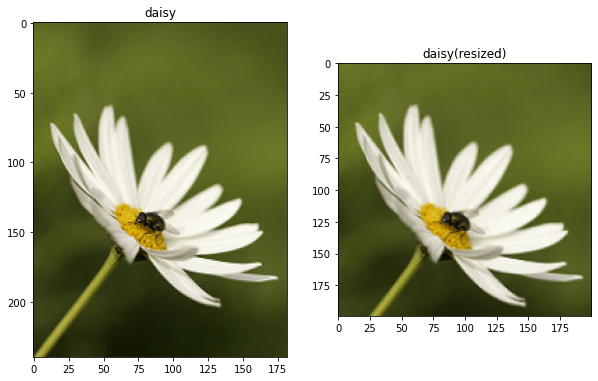

In [46]:
import matplotlib.pyplot as plt

def plot_sample(image, label):
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(flower_names[label])
    
    resized_image, _ = resize_image(image, label)
    plt.subplot(1, 2, 2)
    plt.imshow(resized_image.numpy().astype("uint8"))
    plt.title(flower_names[label] + '(resized)')
    
for image, label in train_ds.take(1):   
    plot_sample(image, label)

# Build Model and Train

In [47]:
"""
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])
"""

"\nmodel = keras.models.Sequential([\n    keras.layers.Flatten(input_shape = (width, height, 3)),\n    keras.layers.Dense(512, activation = 'relu'),\n    keras.layers.Dropout(0.3),\n    keras.layers.Dense(len(flower_names)),\n])\n"

In [81]:
import time

def fit_model(model, train_batch_ds = train_batch_ds, patience = 5, epochs = 20, verbose = 0):
    start = time.time()

    model.compile(
        optimizer = 'adam',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = [keras.metrics.SparseCategoricalAccuracy()],
    )

    early_stopping = keras.callbacks.EarlyStopping(patience = patience, restore_best_weights = True)

    history = model.fit(
        train_batch_ds,
        epochs = epochs,
        validation_data = valid_batch_ds,
        callbacks = [early_stopping],
        verbose = verbose,
    )

    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss')
    print(f'val_loss: {history_df.val_loss.min():.4f} - val_sparse_categorical_accuracy: {history_df.val_sparse_categorical_accuracy.max():.4f}')
    end = time.time()
    print(end - start)
    history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title = 'Accuracy')

In [49]:
%env TF_ENABLE_ONEDNN_OPTS=1
%env TF_ENABLE_ONEDNN_OPTS

env: TF_ENABLE_ONEDNN_OPTS=1


'1'

val_loss: 12.5725 - val_sparse_categorical_accuracy: 0.2425
6.457322120666504


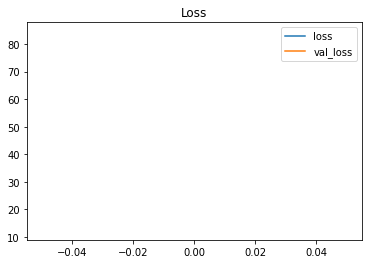

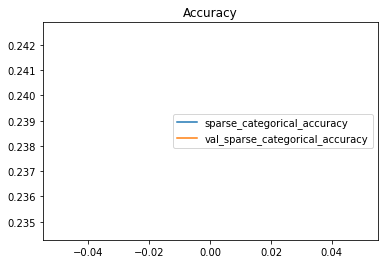

In [51]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model, epochs = 1)

val_loss: 1.5956 - val_sparse_categorical_accuracy: 0.2425
32.17091083526611


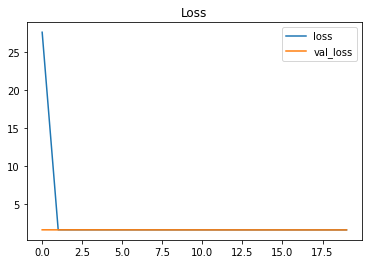

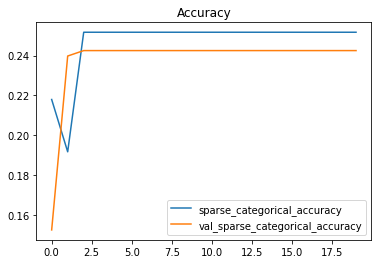

In [52]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.3926 - val_sparse_categorical_accuracy: 0.3787


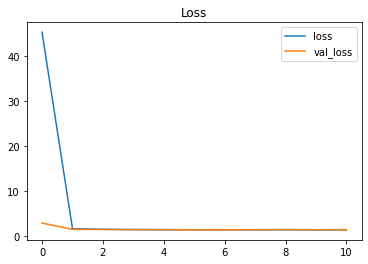

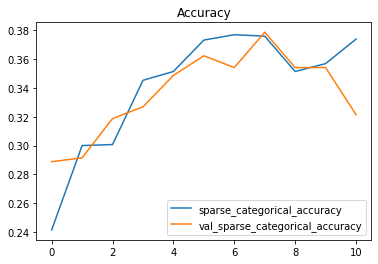

In [47]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.3585 - val_sparse_categorical_accuracy: 0.4251


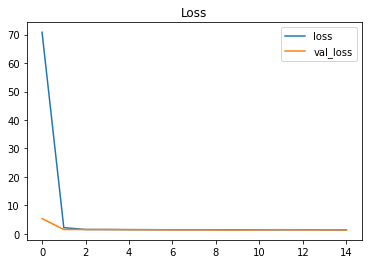

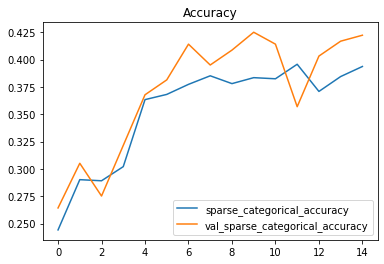

In [49]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.3546 - val_sparse_categorical_accuracy: 0.4332
137.95959615707397


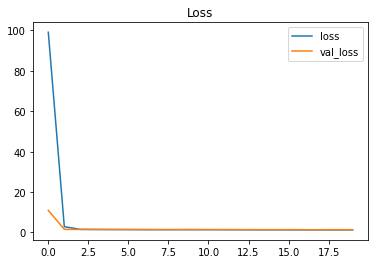

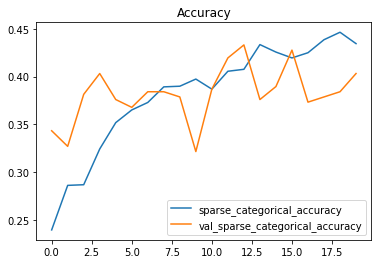

In [53]:
tf.random.set_seed(1)
np.random.seed(1)

# Best so far: val_loss: 1.2919 - val_sparse_categorical_accuracy: 0.4986
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(768, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.2345 - val_sparse_categorical_accuracy: 0.4932


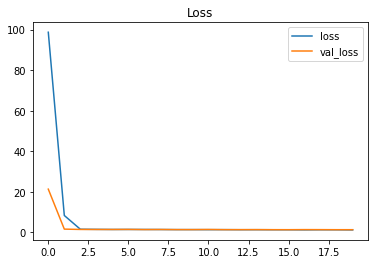

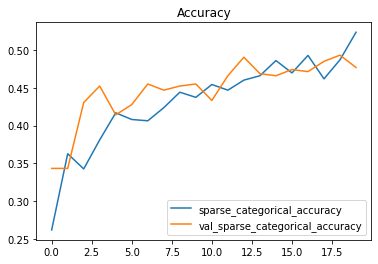

In [51]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.2547 - val_sparse_categorical_accuracy: 0.4850


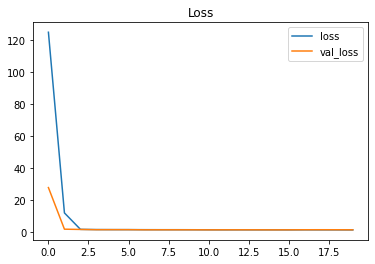

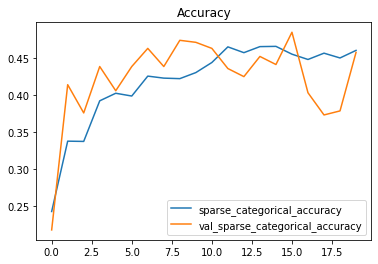

In [52]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(1024+256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.2773 - val_sparse_categorical_accuracy: 0.4605


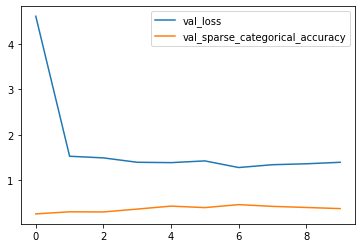

In [37]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(768, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.3523 - val_sparse_categorical_accuracy: 0.4196


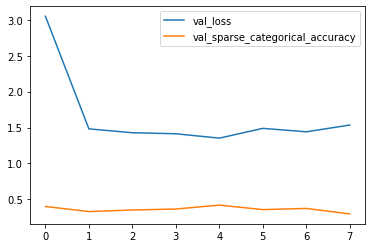

In [38]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(768, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.3927 - val_sparse_categorical_accuracy: 0.3896


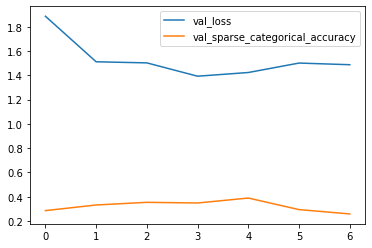

In [39]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(768, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(768, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.3404 - val_sparse_categorical_accuracy: 0.4060


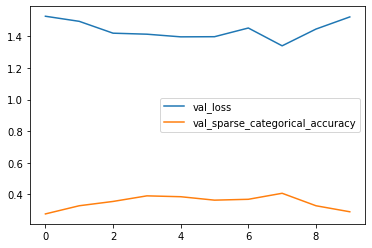

In [40]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.3308 - val_sparse_categorical_accuracy: 0.3733


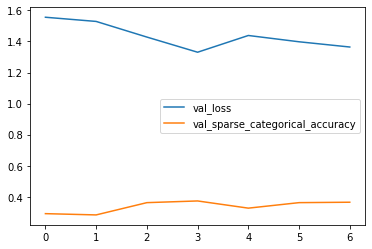

In [41]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (width, height, 3)),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

In [13]:
print(len(flower_names))
print((width, height, 3))

5
(200, 200, 3)


# Build CNN Model

val_loss: 0.9651 - val_sparse_categorical_accuracy: 0.6540


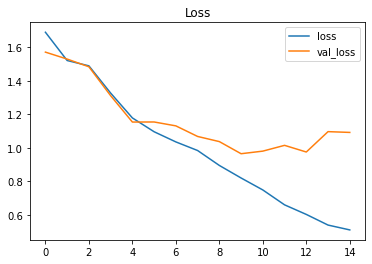

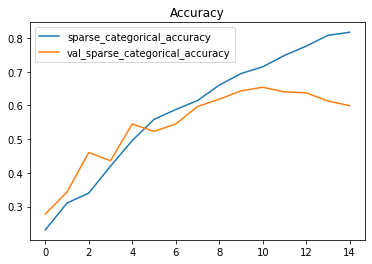

In [54]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(32, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 0.9663 - val_sparse_categorical_accuracy: 0.6594


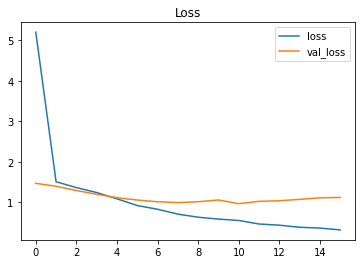

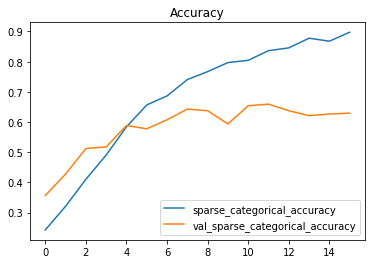

In [55]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(8, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 0.9842 - val_sparse_categorical_accuracy: 0.6540
165.6972460746765


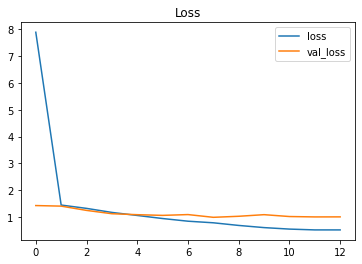

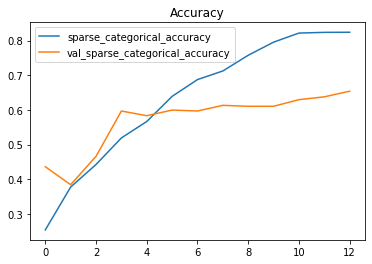

In [98]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(16, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.0834 - val_sparse_categorical_accuracy: 0.6349
229.10933017730713


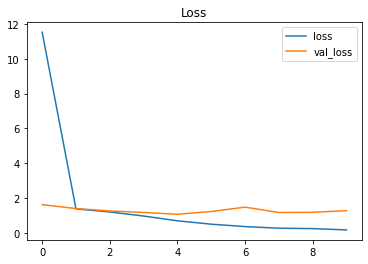

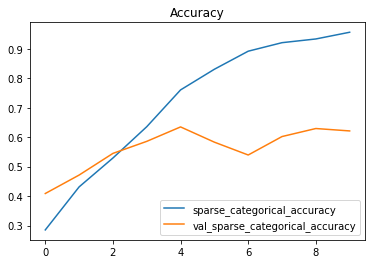

In [15]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(32, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 0.9929 - val_sparse_categorical_accuracy: 0.6458
184.73197221755981


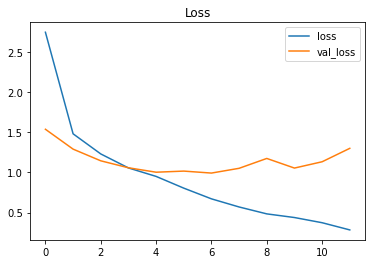

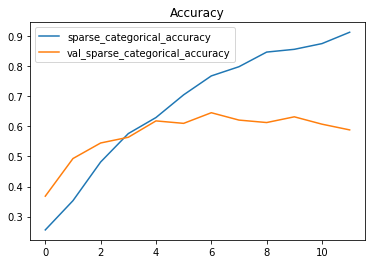

In [16]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(16, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.0688 - val_sparse_categorical_accuracy: 0.5831
152.8708689212799


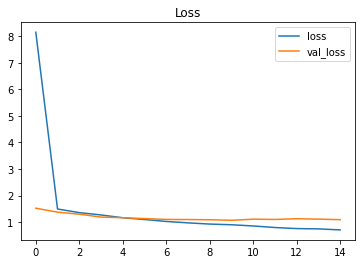

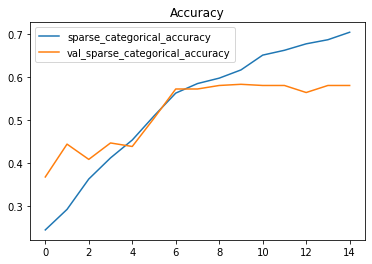

In [17]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(16, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 0.9828 - val_sparse_categorical_accuracy: 0.6757
172.5468111038208


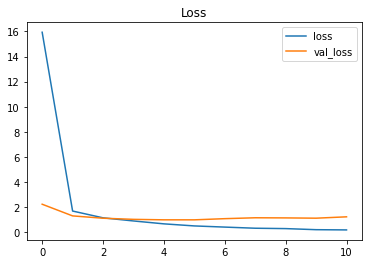

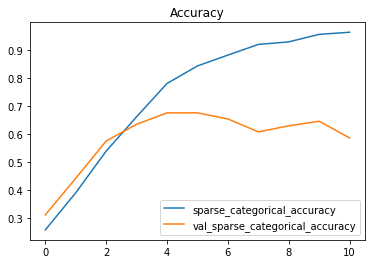

In [18]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(16, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.0082 - val_sparse_categorical_accuracy: 0.6676
175.16171407699585


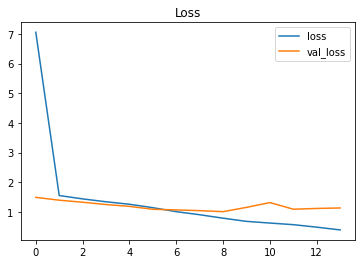

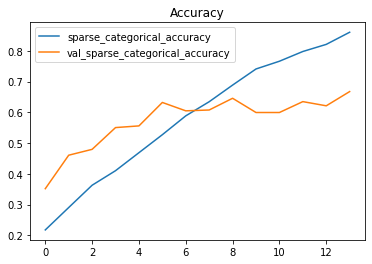

In [19]:
tf.random.set_seed(1)
np.random.seed(1)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(16, 3, activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

val_loss: 1.0012 - val_sparse_categorical_accuracy: 0.6213
240.18468713760376


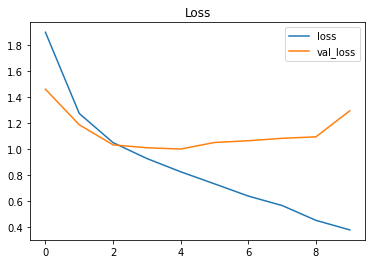

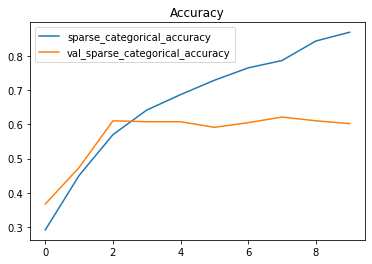

In [31]:
tf.random.set_seed(1)
np.random.seed(1)

# https://www.tensorflow.org/tutorials/images/classification
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model)

# Data Augmentation and Dropout

When there is few training data, the model learns from noises and causes over-fitting.

We try to increase the training data by data augmentation.

This part mainly follows

* [The image classification tutorial](https://www.tensorflow.org/tutorials/images/classification)
  * Add augmentation in model layer

* [Data augmentation tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation)
  * Add augmentation in training set (We choose this approach)

(212, 320, 3)


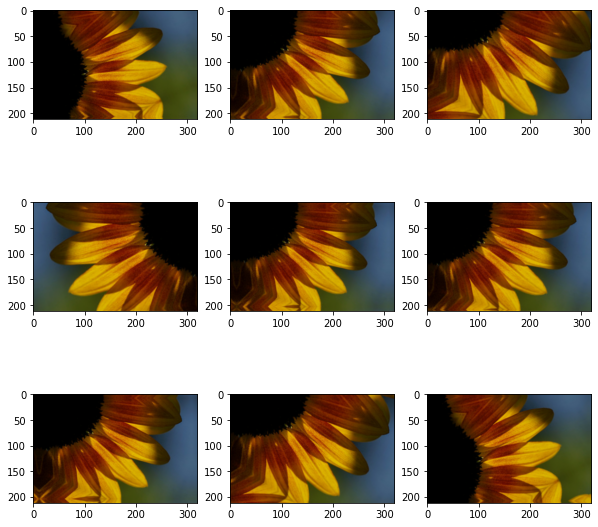

In [78]:
image_augmentations = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (width, height, 3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

def augment_image(image, label):
    return image_augmentations(image), label

plt.figure(figsize = (10 ,10))
for image, _ in train_ds.take(1):
    print(image.shape)
    for i in range(9):
        # The input and output are batch so we add a new axis
        augmented_image = image_augmentations(image.numpy()[np.newaxis, ...])
        ax = plt.subplot(3, 3, i+1)
        plt.imshow((augmented_image[0].numpy()).astype('uint8'))

In [82]:
# We only perform data augmentation on training set
augmented_train_batch_ds = create_train_batch_ds(train_ds, first_transformations, augment_image)

val_loss: 0.7900 - val_sparse_categorical_accuracy: 0.7139
520.8576159477234


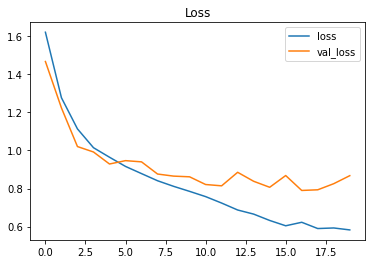

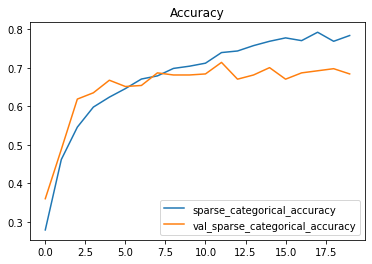

In [83]:
tf.random.set_seed(1)
np.random.seed(1)

# https://www.tensorflow.org/tutorials/images/classification
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (width, height, 3)),
    keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(flower_names)),
])

fit_model(model, train_batch_ds = augmented_train_batch_ds)

# Evaluation

In [85]:
result = model.evaluate(test_batch_ds)

3/3 [==============================] - 1s 214ms/step - loss: 0.6898 - sparse_categorical_accuracy: 0.7466


# Predict on New Data

In [94]:
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('592px-Red_sunflower.jpg', origin = sunflower_url)

img = keras.preprocessing.image.load_img(sunflower_path, target_size = (width, height))
img = keras.preprocessing.image.img_to_array(img)

predictions = model.predict(tf.expand_dims(img, 0))
prediction = predictions[0]
print(prediction)

probs = tf.nn.softmax(prediction).numpy()
print(probs)
label = np.argmax(probs)
print(flower_names[label])

[ -803.96436  -1950.3151     213.69614   1136.5825     -57.369003]
[0. 0. 0. 1. 0.]
sunflowers


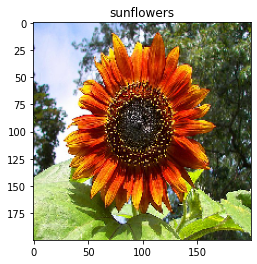

In [97]:
plt.imshow(img.astype("uint8"))
_ = plt.title(flower_names[label])